In [1]:
from keras.models import load_model,Sequential
from keras.layers import Input, Dense, LSTM,Dropout
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint


import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix , accuracy_score

def signal_to_catagorical(data):
  data.loc[data['Signal'] == 'wait ot hold', 'Signal'] = 'wait or hold'
  data.loc[data['Signal'] == 'buy', 'Signal'] = 0
  data.loc[data['Signal'] == 'sell', 'Signal'] = 1 
  data.loc[data['Signal'] == 'wait or hold', 'Signal'] = 2 
  return data

def add_shift_day(data,day):
  r_list = []
  for i in range(day,len(data)):#Number mean day to shift
    r_list.append(data[i-day : i])
  return np.array(r_list)



In [2]:
datalist = [f for f in glob.glob("../../Dataset/*.csv")]
print('have stock = ',len(datalist))

have stock =  75


In [3]:
#validation 
val_list = []
for val_name in range(71,72):
    df = pd.read_csv(datalist[val_name])
    val_x = df
    # val_x = add_shift_day(val_x,30)
    val_list.append(val_x)

#test
test_list = []
for test_name in range(72,75):
    df = pd.read_csv(datalist[test_name])
    test = df
    # test = add_shift_day(test,30)
    test_list.append(test)

In [5]:
model = Sequential()
model.add(LSTM(100, input_shape=((7,6)),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

checkpoint = ModelCheckpoint('Model2_checkpoint.h5',
                               verbose=1,
                               monitor='val_acc',
                               mode='max',
                               save_best_only = True)



In [ ]:
er = []
for train_name in range(0,70):
    try:
        df = pd.read_csv(datalist[train_name])
        df = signal_to_catagorical(df)
#         df = df[30:]
        x_train = df[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
        x_train = add_shift_day(x_train,7)
        y_train = df['Signal'] 
        y_train = to_categorical(y_train)
        y_train = y_train.tolist()
        del y_train[0:7]
        y_train = np.array(y_train)

        r = random.randint(0,2)
        val = val_list[0]
        val = signal_to_catagorical(val)
        x_val = val[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
        x_val = add_shift_day(x_val,7)
        y_val = val['Signal']
        y_val = to_categorical(y_val)
        y_val = y_val.tolist()
        del y_val[0:7]
        y_val = np.array(y_val)

        h = model.fit(x_train, y_train, epochs=100,validation_data=(x_val,y_val),callbacks=[checkpoint],shuffle=False)
        model.save('Model2_'+str(train_name)+'.h5')
        plt.plot(h.history['acc'])
        plt.plot(h.history['val_acc'])
        plt.legend(['train', 'val'])
        plt.show()
    except:
            er.append(datalist[train_name])
    print(er)


Epoch 1/100
91/95 [===========================>..] - ETA: 0s - loss: 1.3077 - acc: 0.7019
Epoch 00001: val_acc did not improve from 0.63573
95/95 [==============================] - 1s 14ms/step - loss: 1.3162 - acc: 0.6910 - val_loss: 1.7563 - val_acc: 0.5303
Epoch 2/100
91/95 [===========================>..] - ETA: 0s - loss: 0.7034 - acc: 0.7236
Epoch 00002: val_acc did not improve from 0.63573
95/95 [==============================] - 1s 13ms/step - loss: 0.7216 - acc: 0.7178 - val_loss: 1.6578 - val_acc: 0.5425
Epoch 3/100
91/95 [===========================>..] - ETA: 0s - loss: 0.6047 - acc: 0.7682
Epoch 00003: val_acc did not improve from 0.63573
95/95 [==============================] - 1s 13ms/step - loss: 0.6220 - acc: 0.7629 - val_loss: 1.6786 - val_acc: 0.5401
Epoch 4/100
31/95 [========>.....................] - ETA: 0s - loss: 0.5073 - acc: 0.8246['../../Dataset\\A(2003,2015).csv']
Epoch 1/100
67/71 [===========================>..] - ETA: 0s - loss: 0.8052 - acc: 0.6866
Epoch

In [23]:
model = load_model('Model2_69.h5')

In [24]:
for test in test_list:
    # print(test)
    test = signal_to_catagorical(test)
    #   print(test)
    x_test = test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
    x_test = add_shift_day(x_test,7)
    y_test = test['Signal'].values
    y_test = y_test.tolist()
    del y_test[0:7]
    y_test = np.array(y_test)

    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis = -1)
    y_test = y_test.astype('int64')
    cm = confusion_matrix(y_test, y_pred)
    ac = accuracy_score(y_test,y_pred)
    print("Confusion Matrix")
    print(cm)
    print("Accuracy")
    print(ac)

Confusion Matrix
[[ 100    2  250]
 [  12   15  209]
 [ 254   43 1588]]
Accuracy
0.6886372826526486
Confusion Matrix
[[ 280   16  230]
 [  34   29  247]
 [ 379   58 1357]]
Accuracy
0.6334600760456274
Confusion Matrix
[[ 215    8  258]
 [  66   29  320]
 [ 331   61 1387]]
Accuracy
0.6097196261682243


C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

Text(0.5, 0, 'Date')

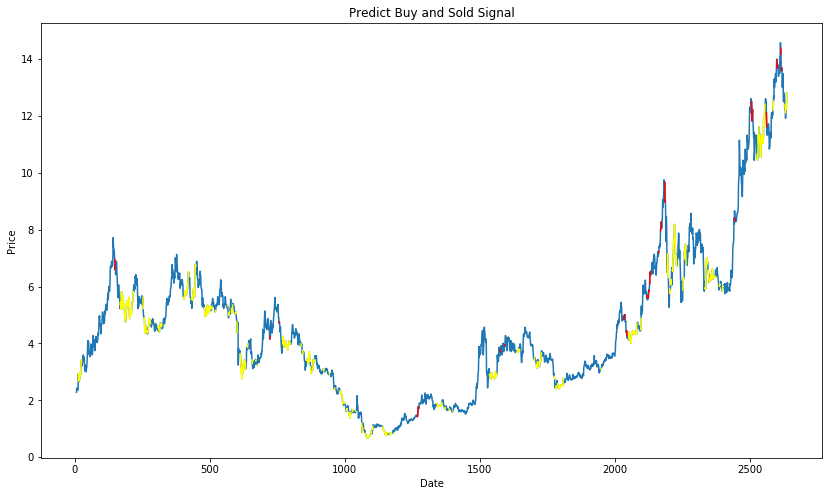

In [27]:
p_test = test_list[1]
p_test = signal_to_catagorical(p_test)
x_test = p_test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
x_test = add_shift_day(x_test,7)
y_test = p_test['Signal'].values
y_test = y_test.tolist()
del y_test[0:7]
y_test = np.array(y_test)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = -1)
p_test = p_test.iloc[7:]

p_test['pred'] = y_pred
p_test['pred_b'] = np.where(p_test['pred'] == 0,p_test['Close'],np.nan)
p_test['pred_s'] = np.where(p_test['pred'] == 1,p_test['Close'],np.nan)

plt.figure(figsize=(14,8))
# plt.grid()
plt.title('Predict Buy and Sold Signal')
plt.plot(p_test['Close'])
plt.plot(p_test['pred_b'],color='yellow')
plt.plot(p_test['pred_s'],color='red')
plt.ylabel('Price')
plt.xlabel('Date')